In [7]:
# Libraries
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import numpy as np
import glob
import torchvision.transforms.v2 as v2
from typing import Optional, Tuple, Dict, List, Any
from torch.utils.data import DataLoader
terrabyte = False

In [8]:
if terrabyte:
    # HPC Terrabyte
    # adapt the user to your needs
    USER = "di97ren"
    # keep the following unchanged
    ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
    USER_PATH = ROOT / f"users/{USER}"
    DATA_PATH = ROOT / "data"

    # when you are on a local dev client
    # uncomment these lines and make necessary ajdustments
    #ROOT = Path("C:/projects/hands-on-DL")
    #DATA_PATH = Path("../data")

    # Configure the path to the GWHD dataset for your environment
    DATASET_ROOT = DATA_PATH / "xview2-subset"

    IMG_PATH = DATASET_ROOT / "png_images"
    TARGET_PATH = DATASET_ROOT / 'targets'

else: 
    ROOT = Path(r"C:\Users\elena\Documents\04-geo-oma\data")
    DATASET_ROOT = ROOT / "xview2-subset"

    IMG_PATH = DATASET_ROOT / "png_images"
    TARGET_PATH = DATASET_ROOT / 'targets'


# Dataset Class

In [9]:
def transform():
    """Transform für Bilder & Masken"""
    return v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomRotation(degrees=15),
        v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        v2.ToDtype(torch.float32, scale=True)  # Automatische Skalierung auf [0,1]
    ])

def image_transform():
    """Nur für RGB-Bilder"""
    return v2.Compose([
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: str,
                 transform: callable = None,
                 image_transform: callable = None):
        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
            pre_target_path = pre_target_path = self.target_path / pre_img_path.name


            if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

        # super().__init__()

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, index):
        pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

        # load images and target masks with 
        
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        pre_target_mask = Image.open(pre_target_path).convert('L')
        post_target_mask = Image.open(post_target_path).convert('L')

        # convert to numpy arrays
        pre_img = np.array(pre_img, dtype=np.float32) / 255.0
        post_img = np.array(post_img, dtype=np.float32) / 255.0
        pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
        post_target_mask = np.array(post_target_mask, dtype=np.float32)

        # convert to Tensor
        pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        post_img = torch.tensor(post_img).permute(2, 0, 1)
        pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
        post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

    # Transformation (optional)


        if self.transform:
            stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
            stack = self.transform(stack)

            pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
        
        if self.image_transform:
            
            # Nur auf Bilder Normalisierung anwenden
            pre_img = self.image_transform(pre_img)
            post_img = self.image_transform(post_img)

        return pre_img, post_img, pre_target_mask, post_target_mask 
    

    
        
        

# Data Loader

## my dataloader: 

In [10]:
def collate_fn(batch):
      # Extrahieren der einzelnen Daten aus der Batch-Liste
    pre_imgs, post_imgs, pre_masks, post_masks = zip(*batch)

    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)
    pre_masks = torch.stack(pre_masks, dim=0)
    post_masks = torch.stack(post_masks, dim=0)

    return pre_imgs, post_imgs, pre_masks, post_masks

# from torch.utils.data import DataLoader

# dataloader = DataLoader(
#     dataset = xView2Dataset(
#         png_path= IMG_PATH,
#         target_path=  TARGET_PATH,
#         transform = transform(),
#         image_transform=image_transform()
#     ),
#     batch_size= 5, 
#     collate_fn = collate_fn,
#     shuffle= True,
#     # TODO - Hier tritt immer ein Fehler auf wenn ich num_workers>0 und prefetch factor auswähle. wieso weiß ich nicht. 
#     # num_workers=0,
#     # prefetch_factor=2, # number of preloaded batches for each workre
#     drop_last= True
# )


In [22]:
# Beispiel, wie du durch den DataLoader iterierst
for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
    print(f"Pre-Disaster Batch Shape: {pre_imgs.shape}")
    print(f"Post-Disaster Batch Shape: {post_imgs.shape}")
    print(f"Pre-Mask Batch Shape: {pre_masks.shape}")
    print(f"Post-Mask Batch Shape: {post_masks.shape}")

Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])


# Model Design

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.segmentation import fcn_resnet50

class UNetResNet50(nn.Module):
    def __init__(self, num_classes):
        super(UNetResNet50, self).__init__()
        
        # Backbone (ResNet50)
        resnet = models.resnet50(pretrained=True)
        resnet.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Removing the last fully connected layers

        # Decoder (simple FCN Decoder)
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, num_classes, kernel_size=1)  # Output layer based on num_classes
        )

        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.upsample(x)
        return x

class SiameseUNet(nn.Module):
    def __init__(self):
        super(SiameseUNet, self).__init__()
        self.unet_pre = UNetResNet50(num_classes=2)  # 2 classes for Pre-Disaster
        self.unet_post = UNetResNet50(num_classes=5)  # 5 classes for Post-Disaster

    def forward(self, pre_img, post_img):
        pre_features = self.unet_pre(pre_img)
        post_features = self.unet_post(post_img)
        return pre_features, post_features


In [12]:

train_dataloader = DataLoader(
    dataset = xView2Dataset(
        png_path= IMG_PATH,
        target_path=  TARGET_PATH,
        transform = transform(),
        image_transform=image_transform()
    ),
    batch_size= 5, 
    collate_fn = collate_fn,
    shuffle= True,
    # TODO - Hier tritt immer ein Fehler auf wenn ich num_workers>0 und prefetch factor auswähle. wieso weiß ich nicht. 
    # num_workers=0,
    # prefetch_factor=2, # number of preloaded batches for each workre
    drop_last= True
)


In [ ]:
model = SiameseUNet()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")_ = model.to(device)

c:\Users\elena\Documents\04-geo-oma\assignment_04_geo_oma24-xView2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elena\Documents\04-geo-oma\assignment_04_geo_oma24-xView2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:

if __name__ == "__main__":
    # Modell initialisieren
    model = SiameseUNet()

    # Beispielhafte Batch abrufen (dataloader is assumed to be defined)
    pre_imgs, post_imgs, pre_masks, post_masks = next(iter(dataloader))

    # Modell-Vorhersage
    pre_output, post_output = model(pre_imgs, post_imgs)

    print("Pre-Disaster Output Shape:", pre_output.shape)
    print("Post-Disaster Output Shape:", post_output.shape)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    pre_imgs, post_imgs = pre_imgs.to(device), post_imgs.to(device)

    pre_output, post_output = model(pre_imgs, post_imgs)


Pre-Disaster Output Shape: torch.Size([5, 2, 256, 256])
Post-Disaster Output Shape: torch.Size([5, 5, 256, 256])


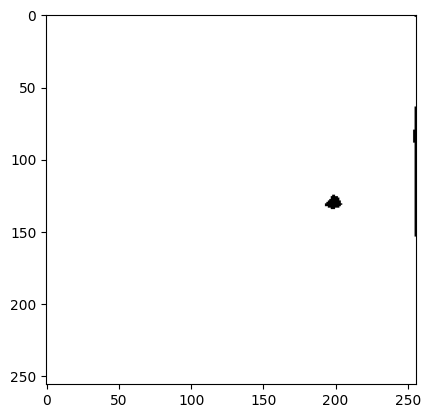

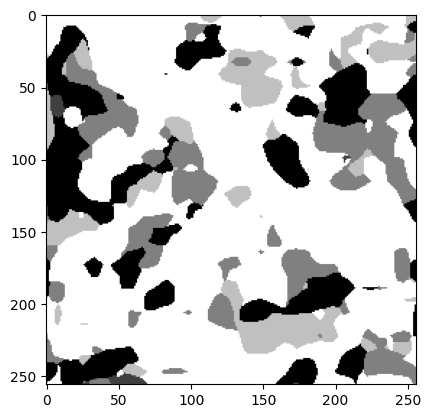

In [40]:
import matplotlib.pyplot as plt

pre_segmentation = pre_output.argmax(dim=1)[2].cpu().numpy()  # Wähle erstes Bild & nehme die Klasse mit höchster Wahrscheinlichkeit
plt.imshow(pre_segmentation, cmap="gray")
plt.show()

post_segmentation = post_output.argmax(dim=1)[2].cpu().numpy()
plt.imshow(post_segmentation, cmap = 'gray')
plt.show()
